# Lab 17: CIFAR multi-layer -- solution

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import utils
import time

### With or without GPU?

In [2]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


### Download the CIFAR dataset 

In [3]:
from utils import check_cifar_dataset_exists
check_cifar_dataset_exists() 

train_data=torch.load('../data/cifar/train_data.pt')
train_label=torch.load('../data/cifar/train_label.pt')
test_data=torch.load('../data/cifar/test_data.pt')
test_label=torch.load('../data/cifar/test_label.pt')

print(train_data.size())

torch.Size([50000, 3, 32, 32])


### Make a Three layer net class. 

In [4]:
class three_layer_net(nn.Module):

    def __init__(self, input_size, hidden_size1, hidden_size2,  output_size):
        super(three_layer_net , self).__init__()

        self.layer1 = nn.Linear(  input_size   , hidden_size1  , bias=False  )
        self.layer2 = nn.Linear(  hidden_size1 , hidden_size2  , bias=False  )
        self.layer3 = nn.Linear(  hidden_size2 , output_size   , bias=False  )        
        
    def forward(self, x):
        
        y       = self.layer1(x)
        y_hat   = F.relu(y)
        z       = self.layer2(y_hat)
        z_hat   = F.relu(z)
        scores  = self.layer3(z_hat)
        
        return scores

### Build the net with the following size:
* input size = 3,072
* hidden size 1 = 500
* hidden size 2 = 500
* output size = 10
### How many parameters in total? (the one layer net had 30,000 parameters)

In [5]:
net=three_layer_net(3072,500,500,10)
print(net)
utils.display_num_param(net)

three_layer_net(
  (layer1): Linear(in_features=3072, out_features=500, bias=False)
  (layer2): Linear(in_features=500, out_features=500, bias=False)
  (layer3): Linear(in_features=500, out_features=10, bias=False)
)
There are 1791000 (1.79 million) parameters in this neural network


### Send the weights of the networks to the GPU

In [ ]:
net = net.to(device)

### Choose the criterion and optimizer. Also choose:
* batch size =200
* learning rate =0.01


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.SGD( net.parameters() , lr=0.01 )
bs= 200

### Function to evaluate the network on the test set

In [8]:
def eval_on_test_set():

    running_error=0
    num_batches=0


    for i in range(0,10000,bs):

        # extract the minibatch
        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)

        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)

        # feed it to the network
        scores=net( inputs ) 

        # compute the error made on this batch
        error = utils.get_error( scores , minibatch_label)

        # add it to the running error
        running_error += error.item()

        num_batches+=1


    # compute error rate on the full test set
    total_error = running_error/num_batches

    print( 'error rate on test set =', total_error*100 ,'percent')

### Do 200 passes through the training set.

In [9]:
start=time.time()

for epoch in range(1000):
    
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(50000)
 
    for count in range(0,50000,bs):
    
        # Set the gradients to zeros
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label=  train_label[indices]
        
        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        # reshape the minibatch
        inputs = minibatch_data.view(bs,3072)

        # tell Pytorch to start tracking all operations that will be done on "inputs"
        inputs.requires_grad_()

        # forward the minibatch through the net 
        scores=net( inputs ) 

        # Compute the average of the losses of the data points in the minibatch
        loss =  criterion( scores , minibatch_label) 
        
        # backward pass to compute dL/dU, dL/dV and dL/dW   
        loss.backward()

        # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
        optimizer.step()
        

        # START COMPUTING STATS
        
        # add the loss of this batch to the running loss
        running_loss += loss.detach().item()
        
        # compute the error made on this batch and add it to the running error       
        error = utils.get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1        
    
    
    # compute stats for the full training set
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed = time.time()-start
    
    if epoch%20 == 0:
        print('epoch=',epoch, '\t time=', elapsed, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        eval_on_test_set() 
        print(' ')
    
    
        
        

epoch= 0 	 time= 1.0180513858795166 	 loss= 2.2436988945007323 	 error= 82.08200056552887 percent
error rate on test set = 77.23999989032745 percent
 
epoch= 20 	 time= 21.481289625167847 	 loss= 1.589706464290619 	 error= 55.88200109004975 percent
error rate on test set = 55.90000140666962 percent
 
epoch= 40 	 time= 41.989662885665894 	 loss= 1.416879979133606 	 error= 50.10800030231476 percent
error rate on test set = 52.260000348091125 percent
 
epoch= 60 	 time= 62.469945669174194 	 loss= 1.304539535522461 	 error= 46.102000927925104 percent
error rate on test set = 50.82000005245209 percent
 
epoch= 80 	 time= 82.98795866966248 	 loss= 1.2114149150848388 	 error= 42.56800122261048 percent
error rate on test set = 48.39000070095062 percent
 
epoch= 100 	 time= 103.45038080215454 	 loss= 1.1215246868133546 	 error= 39.36400127410889 percent
error rate on test set = 46.62000072002411 percent
 
epoch= 120 	 time= 123.73420190811157 	 loss= 1.0397299275398255 	 error= 36.4420016765594

### Choose image at random from the test set and see how good/bad are the predictions

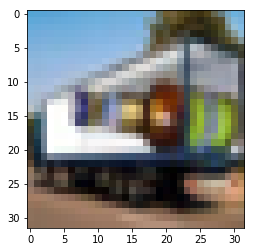

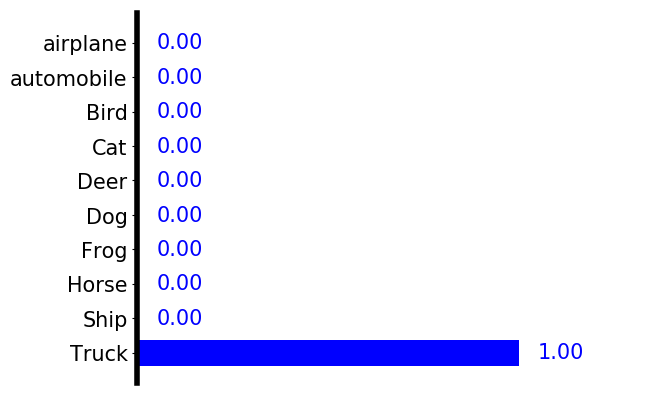

In [10]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
utils.show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,3072).to(device)) 
probs= F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())